## Домашнее задание 7##

In [85]:
import pandas as pd
import numpy as np

import shap

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

**Для решения задачи был выбран датасет https://archive.ics.uci.edu/ml/datasets/Adult**

In [12]:
df = pd.read_csv(
    'adult.csv', sep=',', index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
           'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'])

- **age:** возраст
- **workclass:** рабочий класс
- **fnlwgt:** что то
- **education:** образование
- **education-num:** образование количество или время
- **marital-status:** семейное положение
- **occupation:** род деятельности
- **relationship:** Отношения
- **race:** раса
- **sex:** пол
- **capital-gain:** прирост капитала
- **capital-loss:** потери капитала
- **hours-per-week:** часов работы в неделю
- **native-country:** страна рождения
- **income:** доход

**- сделать обзорный анализ выбранного датасета**

In [13]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null int64
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null int64
dtypes: int64(8), object(7)
memory usage: 3.7+ MB


In [15]:
df.describe()

,age,fnlwgt,education-num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Нужно детальнее рассмотреть capital-gain и capital-loss

In [59]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

workclass

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
****************************************************************************************************

education

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
****************************************************************************************************

marital-status

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated          

- workclass категория ? исследовать на возможность объединения
- sex заменить на 1 и 0
- native-country категория ? исследовать на возможность объединения
- income заменить на 1 и 0

**- сделать feature engineering**

In [17]:
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
df['sex'] = df['sex'].map({' Female': 0, ' Male': 1})
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0


In [18]:
#Убираем пробелы в значениях
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Оценка признака "workclass" в разрезе целевой переменной

In [35]:
def get_ratio(column, category):
    column_1 = len(df.loc[(df[column] == category) & (df['income'] == 1)])
    column_sum = len(df.loc[(df[column] == category)])
    print(f'Доля целевого призака в {category} = {column_1/column_sum}')

In [65]:
def xi_valid (column, category_1, category_2):
    column_and_target = df.loc[(df[column] == category_1) | (df[column] == category_2), [column, 'income']]
    column_and_target['ID'] = column_and_target.index.tolist()
    table = column_and_target.pivot_table(values='ID', 
                                    index=column, 
                                    columns='income', 
                                    aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    
    
    print(table)
    print(f'p = {p}')

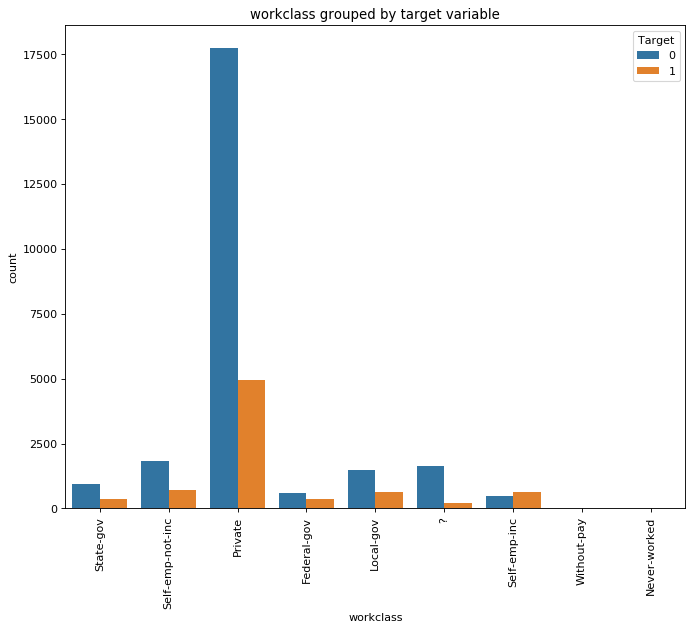

In [61]:
#Оценка признака в разрезе целевой переменной
plt.figure(figsize=(10,8), dpi= 80)
sns.countplot(x='workclass', hue='income', data=df) 
plt.title('workclass grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation=90);

In [66]:
for category in df['workclass'].unique():
    get_ratio('workclass', category)

Доля целевого призака в State-gov = 0.27195685670261943
Доля целевого призака в Self-emp-not-inc = 0.2849271940181031
Доля целевого призака в Private = 0.21867289390200917
Доля целевого призака в Federal-gov = 0.38645833333333335
Доля целевого призака в Local-gov = 0.29479216435738176
Доля целевого призака в ? = 0.10403050108932461
Доля целевого призака в Self-emp-inc = 0.557347670250896
Доля целевого призака в Without-pay = 0.0
Доля целевого призака в Never-worked = 0.0


**Наблюдение**

Из графика и расчета доли целевой переменной можем определить ближайший к '?' признак 'Private' и предположить что их частоты согласованы.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\alpha=0.05$ 
* Критическая область: двухсторонняя

In [67]:
xi_valid ('workclass', 'Private', '?')

income         0     1
workclass             
?           1645   191
Private    17733  4963
p = 4.201224166018686e-31


P-value меньше выбранного уровня значимости, соответственно у нас есть основания для отвержения нулевой гипотезы.

Оценка признака "native_country" в разрезе целевой переменной

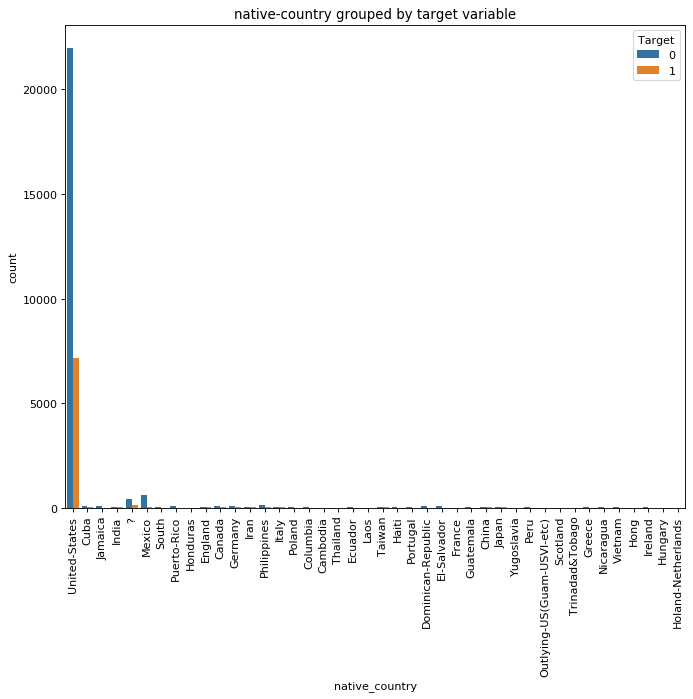

In [34]:
#Оценка признака в разрезе целевой переменной
plt.figure(figsize=(10,8), dpi= 80)
sns.countplot(x='native_country', hue='income', data=df) 
plt.title('native-country grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation=90);

In [36]:
for category in df['native_country'].unique():
    get_ratio('native_country', category)

Доля целевого призака в United-States = 0.24583476174151525
Доля целевого призака в Cuba = 0.2631578947368421
Доля целевого призака в Jamaica = 0.12345679012345678
Доля целевого призака в India = 0.4
Доля целевого призака в ? = 0.2504288164665523
Доля целевого призака в Mexico = 0.05132192846034215
Доля целевого призака в South = 0.2
Доля целевого призака в Puerto-Rico = 0.10526315789473684
Доля целевого призака в Honduras = 0.07692307692307693
Доля целевого призака в England = 0.3333333333333333
Доля целевого призака в Canada = 0.32231404958677684
Доля целевого призака в Germany = 0.32116788321167883
Доля целевого призака в Iran = 0.4186046511627907
Доля целевого призака в Philippines = 0.30808080808080807
Доля целевого призака в Italy = 0.3424657534246575
Доля целевого призака в Poland = 0.2
Доля целевого призака в Columbia = 0.03389830508474576
Доля целевого призака в Cambodia = 0.3684210526315789
Доля целевого призака в Thailand = 0.16666666666666666
Доля целевого призака в Ecuador

**Наблюдение**

Из графика ничего не видно, но есть предположение, что частоты признаков 'United-States' и '?' согласованы

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\alpha=0.05$ 
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий United-States и ? признака native_country в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [56]:
xi_valid ('native_country', 'United-States', '?')

income              0     1
native_country             
?                 437   146
United-States   21999  7171
p = 0.7986847235352101


P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории United-States и ? одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [58]:
#Заменим '?' на United-States
df.loc[df['native_country'] == '?', 'native_country'] = 'United-States'
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0


**- обучить любой классификатор (какой вам нравится)**

In [89]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [75]:
CAT_FEATURE_NAMES = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'native_country']
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
        'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = ['income']

In [74]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
cat_features = [i for i, col in enumerate(df) if col in CAT_FEATURE_NAMES]
cat_features

[1, 3, 5, 6, 7, 8, 13]

In [77]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

**- разобраться с SHAP и построить важности признаков для всего тестового набора данных (summary_plot - дать интерпретацию)**

In [93]:
model = catb.CatBoostClassifier(iterations=100, random_state=0)
model.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.333044
0:	learn: 0.5384616	total: 17.6ms	remaining: 1.75s
1:	learn: 0.4582744	total: 48.6ms	remaining: 2.38s
2:	learn: 0.4079955	total: 64.4ms	remaining: 2.08s
3:	learn: 0.3783416	total: 80.1ms	remaining: 1.92s
4:	learn: 0.3575490	total: 94.7ms	remaining: 1.8s
5:	learn: 0.3402793	total: 110ms	remaining: 1.72s
6:	learn: 0.3297700	total: 124ms	remaining: 1.65s
7:	learn: 0.3225188	total: 155ms	remaining: 1.79s
8:	learn: 0.3162857	total: 178ms	remaining: 1.8s
9:	learn: 0.3116330	total: 194ms	remaining: 1.74s
10:	learn: 0.3081487	total: 209ms	remaining: 1.69s
11:	learn: 0.3049627	total: 224ms	remaining: 1.64s
12:	learn: 0.3025534	total: 249ms	remaining: 1.66s
13:	learn: 0.3011999	total: 264ms	remaining: 1.62s
14:	learn: 0.2986305	total: 280ms	remaining: 1.58s
15:	learn: 0.2967743	total: 305ms	remaining: 1.6s
16:	learn: 0.2956032	total: 321ms	remaining: 1.57s
17:	learn: 0.2937841	total: 338ms	remaining: 1.54s
18:	learn: 0.2923999	total: 354ms	remaining: 1.51s
19:	learn

In [90]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred_probs = model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18561
           1       0.81      0.67      0.73      5859

    accuracy                           0.88     24420
   macro avg       0.85      0.81      0.83     24420
weighted avg       0.88      0.88      0.88     24420

TEST

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6159
           1       0.77      0.65      0.70      1982

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [122]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

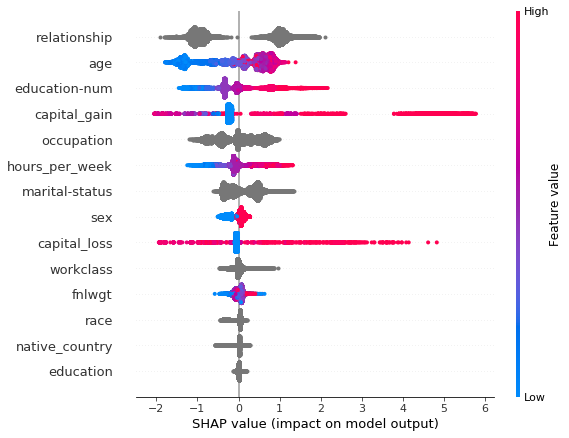

In [125]:
shap.summary_plot(shap_values, X_train)

1. У людей старшего возраста годовой доход выше 50к
2. У людей с большим количеством образований доход выше 50к
3. Те, кто больше времени в неделю работают, у тех доход выше 50к
4. Мужчины зарабатывают больше 50к

 **- разобраться с SHAP и построить важности признаков для топ 10%**

In [103]:
# Найдем границу score для ТОП-10% (это 90-й процентиль)
score_90p = np.percentile(y_test_pred, 90)

# Маска для ТОП-10 (индексы тех объектов, у которых score больше)
top_10_mask = np.where(y_test_pred >= score_90p)

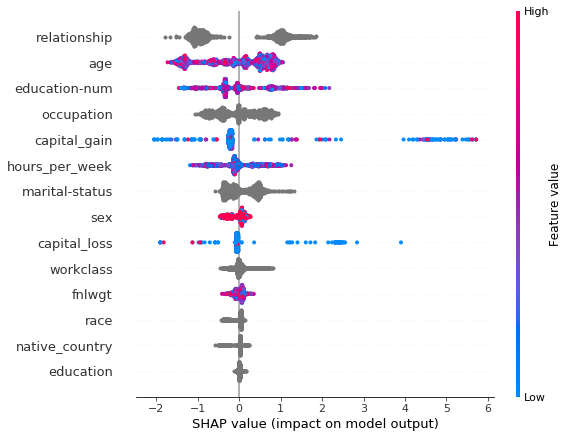

In [116]:
# Для ТОП-10%
shap.summary_plot(shap_values[top_10_mask], X_test.iloc[top_10_mask])

В данном случае четко описать портрет богача не получится.

**- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат**

In [119]:
idx_max = np.argmax(y_test_pred)
shap.force_plot(explainer.expected_value, shap_values[idx_max, :], X_test.iloc[idx_max, :])

Большой вклад здесь внесло наличие статуса "Муж", гражданский брак и работа в сфере транспорта. А вот возраст и количество образований отразилось в понижении.

In [121]:
idx_min = np.argmin(y_test_pred)
shap.force_plot(explainer.expected_value, shap_values[idx_min, :], X_test.iloc[idx_min, :])

Большой вклад здесь внёс возраст, пол (что странно, т.к. он женский) и род деятельности - канцелярия, а вот статус не замужем и количество образований (высокое, что тоже странно) плюс белый цвет кожи понизили результат.